# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [261]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [262]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})

# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]

df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

df_users

,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10-01,1052.0,1960.0,9477.0,21301.0,28.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04-01,1188.0,835.0,19286.0,7182.0,111.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08-01,634.0,576.0,7844.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,0.00000,0.00000,NaN,2013-06-01,2362.0,2434.0,187989.0,87935.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈 •Focused on buildin...,False,God is my refuge; gem❤️,0.00000,0.00000,NaN,2015-12-01,1247.0,961.0,36368.0,26724.0,75.0
5,17938477,1.0,Skelly @SPX B10,SkellyScribbles,"visual artist, writer, and photographer.",False,"Richmond, VA",37.55376,-77.46026,United States,2008-12-01,331.0,497.0,5448.0,8006.0,56.0
6,720288026681716737,1.0,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",False,"Toronto, Ontario",43.70011,-79.41630,Canada,2016-04-01,67.0,70.0,9370.0,37.0,88.0
7,174004739,1.0,marc,_MightyMarc_,NaN,False,NaN,0.00000,0.00000,NaN,2010-08-01,369.0,1879.0,56344.0,132787.0,27.0
8,53783678,1.0,Lady Attis ⚦,ladyattis,Your friendly neighbor androgynous android. Lo...,False,"Minneapolis, MN",44.97997,-93.26384,United States,2009-07-01,755.0,1077.0,39137.0,69192.0,52.0
9,257662370,1.0,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,False,"Seattle, WA",47.60621,-122.33207,United States,2011-02-01,766.0,1374.0,19197.0,9377.0,29.0


Далее необходимо ввести новые признаки. Для каждого пользователя предлагается ввести следующие признаки:
- name_words - количество слов в имени
- screen_name_length - количество символов в псевдониме
- description_length - длина описания
- created_year - год создания аккаунта
- country_code - код страны
- verified - предлагается перевести в тип int

(2 балла)

In [263]:
# Load countries info (Geonames data)
country_data = pd.read_table("country-data.csv", encoding="utf-8", index_col='name')

def country_code(country_name):
    if pd.isnull(country_name):
        return NaN
    else:
        code = country_data['iso numeric'].get(country_name, NaN)
        return code

def nancheck_len(desc):
    return 0 if pd.isnull(desc) else len(desc)
    
def create_new_features(df_users, features):    
    # Introduce new features
    new_features = [
    #    feature name          column to use  function to apply
        ["name_words",         "name",        lambda name: len(name.split()) ],
        ["screen_name_length", "screen_name", lambda nick: len(nick)         ],
        ["description_length", "description", nancheck_len                   ],
        ["created_year",       "created_at",  lambda date: date.year         ],
        ["country_code",       "country",     country_code                   ],
        ["verified",           "verified",    int                            ]
    ]
    
    # Add new features
    features += [f[0] for f in new_features]
    
    # Apply
    for f in new_features:
        df_users[f[0]] = df_users[f[1]].apply(f[2])
    
    pass

In [264]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
create_new_features(df_users, features)

x = df_users[pd.notnull(df_users.cls)][features].values
y = df_users[pd.notnull(df_users.cls)]["cls"].values

df_users

,uid,cls,name,screen_name,description,verified,location,lat,lon,country,...,followers_count,friends_count,statuses_count,favourites_count,listed_count,name_words,screen_name_length,description_length,created_year,country_code
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,0,"Gulfport, FL",27.74836,-82.70343,United States,...,1052.0,1960.0,9477.0,21301.0,28.0,2,12,38,2010,840.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,0,Singapore/Malaysia,1.54860,103.52690,Malaysia,...,1188.0,835.0,19286.0,7182.0,111.0,2,11,159,2013,458.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",0,"Manchester, UK",53.48095,-2.23743,United Kingdom,...,634.0,576.0,7844.0,1141.0,28.0,3,8,129,2011,826.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,0,Marvel. DC.,0.00000,0.00000,NaN,...,2362.0,2434.0,187989.0,87935.0,68.0,1,11,23,2013,NaN
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈 •Focused on buildin...,0,God is my refuge; gem❤️,0.00000,0.00000,NaN,...,1247.0,961.0,36368.0,26724.0,75.0,1,13,159,2015,NaN
5,17938477,1.0,Skelly @SPX B10,SkellyScribbles,"visual artist, writer, and photographer.",0,"Richmond, VA",37.55376,-77.46026,United States,...,331.0,497.0,5448.0,8006.0,56.0,3,15,40,2008,840.0
6,720288026681716737,1.0,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",0,"Toronto, Ontario",43.70011,-79.41630,Canada,...,67.0,70.0,9370.0,37.0,88.0,2,12,86,2016,124.0
7,174004739,1.0,marc,_MightyMarc_,NaN,0,NaN,0.00000,0.00000,NaN,...,369.0,1879.0,56344.0,132787.0,27.0,1,12,0,2010,NaN
8,53783678,1.0,Lady Attis ⚦,ladyattis,Your friendly neighbor androgynous android. Lo...,0,"Minneapolis, MN",44.97997,-93.26384,United States,...,755.0,1077.0,39137.0,69192.0,52.0,3,9,117,2009,840.0
9,257662370,1.0,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,0,"Seattle, WA",47.60621,-122.33207,United States,...,766.0,1374.0,19197.0,9377.0,29.0,3,14,88,2011,840.0


Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, абсолютное значения коэффициента корреляции между которыми больше 0.2. Необходимо реализовать функцию find_correlated_features, в которой нужно рассчитать коэффициенты корелляции и вывести те, которые больше 0.2. Подсказка: предлагается найти необходимую функцию в библиотеке np и реализовать find_correlated_features с использованием не более 5 строк кода (включая заголовок функции). (2 балла)

In [265]:
def find_correlated_features(x, features):
    cor = np.corrcoef(x, rowvar=0)
    
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if i < j and abs(cor[i, j]) > 0.2:
                print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, cor[i, j])

In [266]:
find_correlated_features(x, features)

Correlated features: lat + lon -> -0.63
Correlated features: followers_count + friends_count -> 0.39
Correlated features: followers_count + listed_count -> 0.69
Correlated features: followers_count + verified -> 0.36
Correlated features: friends_count + listed_count -> 0.38
Correlated features: statuses_count + favourites_count -> 0.27
Correlated features: statuses_count + listed_count -> 0.20
Correlated features: statuses_count + created_year -> -0.21
Correlated features: listed_count + verified -> 0.35


Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

Необходимо реализовать функции: plot_two_features_scatter для построения взаимного распределения пары признаков, plot_feature_histogram для построения гистограммы значений, plot_dataset для построения набора графиков по разным парам признаков. (4 балла)

In [267]:
def plot_two_features_scatter(x_i, x_j, y):
    colors = ['green' if cls == 1 else 'red' for cls in y]
    pl.scatter(x_j, x_i, c=colors, s=4, linewidth=0, alpha=0.7)
    
    pass

    
def plot_feature_histogram(x_i, y):
    pos = [f for f, cls in zip(x_i, y) if cls == 1 and pd.notnull(f)]
    neg = [f for f, cls in zip(x_i, y) if cls == 0 and pd.notnull(f)]
    
    pl.hist([pos, neg], color=['green', 'red'], alpha=0.7)
    
    pass


def plot_dataset(x, y, features):
    f = pl.figure(figsize=(15, 15))
    
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            f.add_subplot(len(features), len(features), i * len(features) + (j + 1), xticklabels=[], yticklabels=[])
            
            if i == 0:
                pl.title(feature_j)
            
            if j == 0:
                pl.ylabel(feature_i)

            # Do actual plotting
            if i != j:
                plot_two_features_scatter(x[:, i], x[:, j], y)            
            else:
                plot_feature_histogram(x[:, i], y)
    
    pl.show()

Построим попарные распределения географических признаков ([подсказка](http://stroykova.github.io/sphera/l2_1.png)).

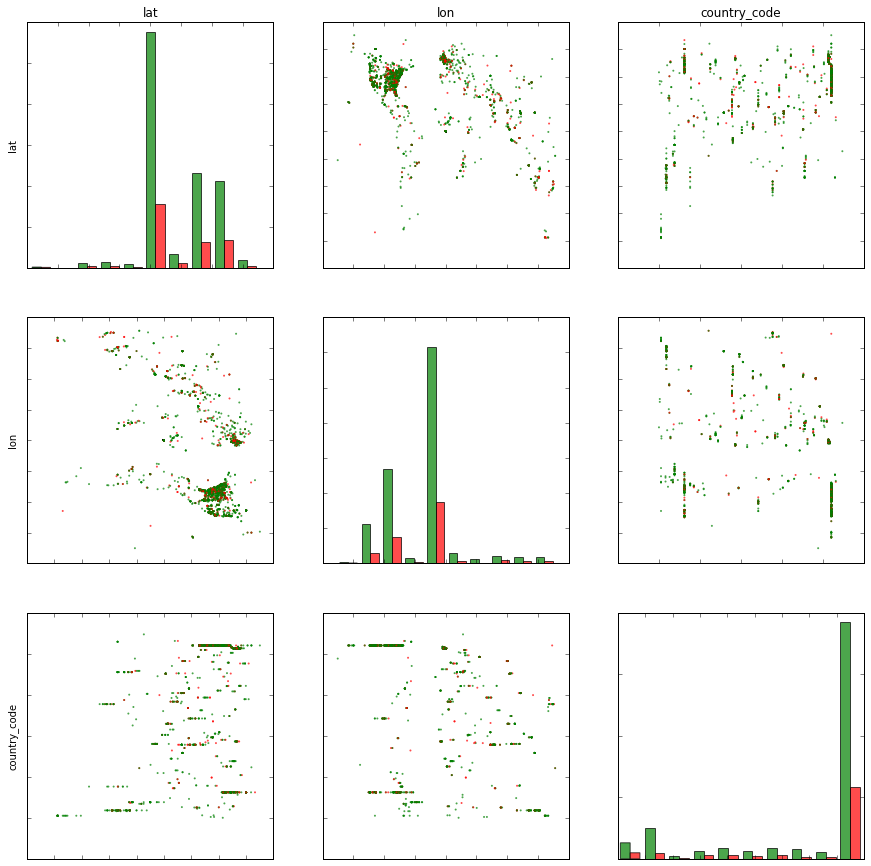

In [268]:
geo_features_new = ["lat", "lon", "country_code"]

geo_features = [f for f in geo_features_new if f in features]
geo_feature_ind = [features.index(f) for f in geo_features]

plot_dataset(x[:, geo_feature_ind], y, geo_features)

Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://stroykova.github.io/sphera/l2_2.png)).

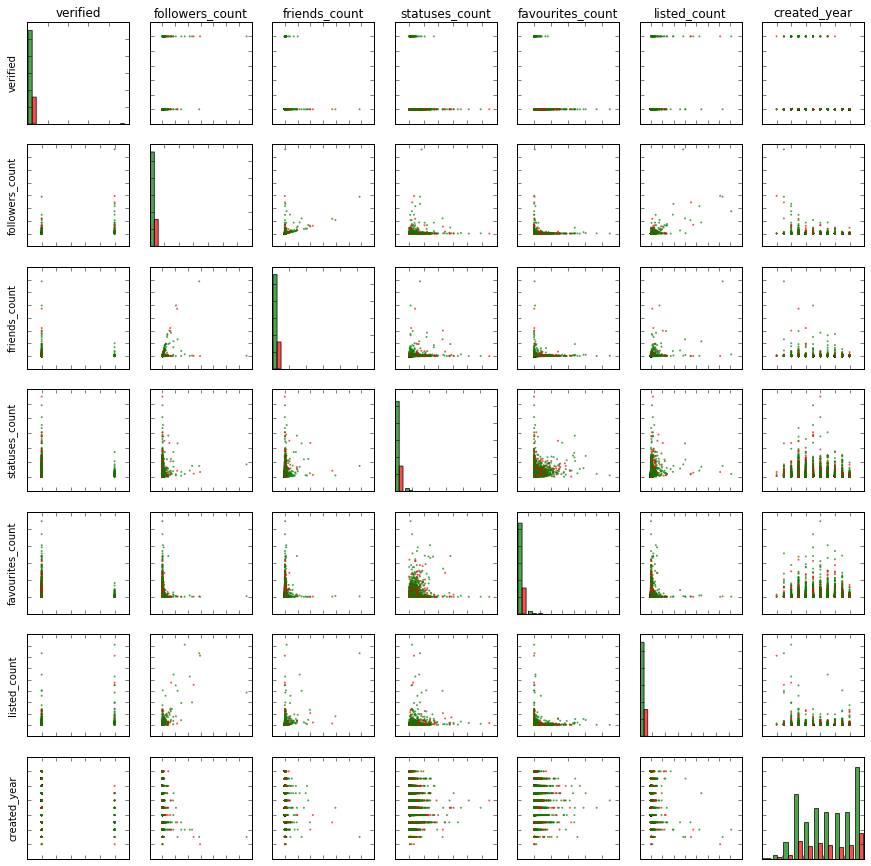

In [269]:
social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]

social_features = [f for f in social_features_new if f in features]
social_feature_ind = [features.index(f) for f in social_features]

plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://stroykova.github.io/sphera/l2_3.png)). Необходимо реализовать функцию log_transform_features, которая выполняет указанное логарифмическое преобразование. (2 балла)

In [270]:
def log_transform_features(data, features, transformed_features):
    transformed_feature_ind = [features.index(f) for f in transformed_features]
    
    data[:, transformed_feature_ind] = np.log(1 + data[:, transformed_feature_ind])
    
    pass

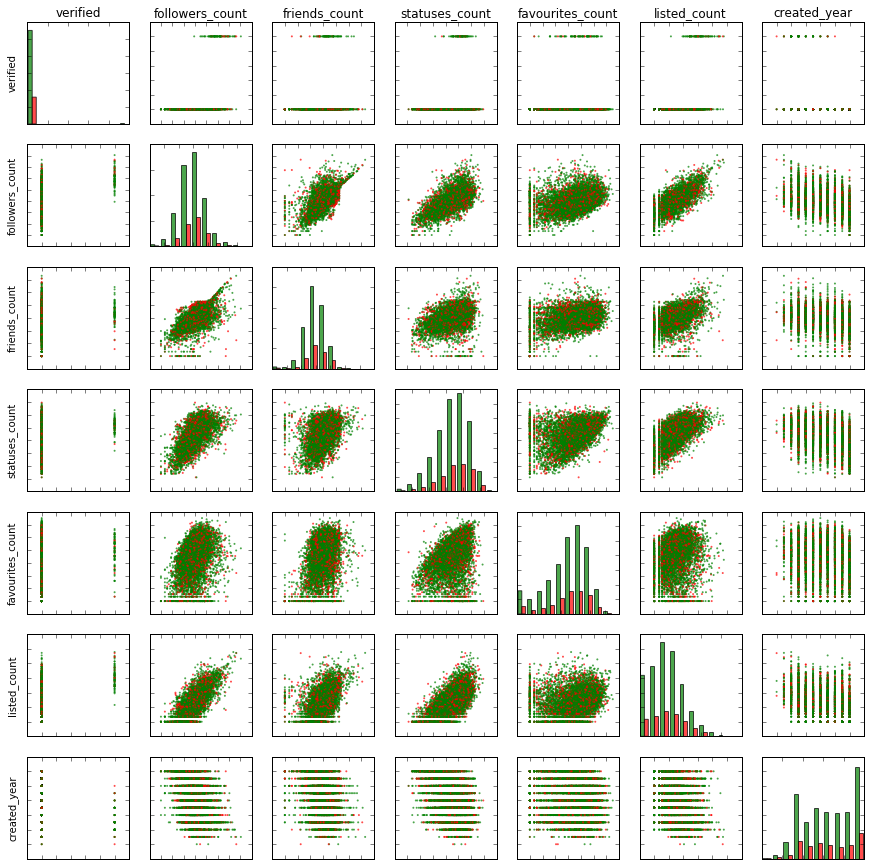

In [271]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
log_transform_features(x, features, transformed_features)

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассматривать признак "verified".

После того как мы с помощью логарифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://stroykova.github.io/sphera/l2_4.png)).

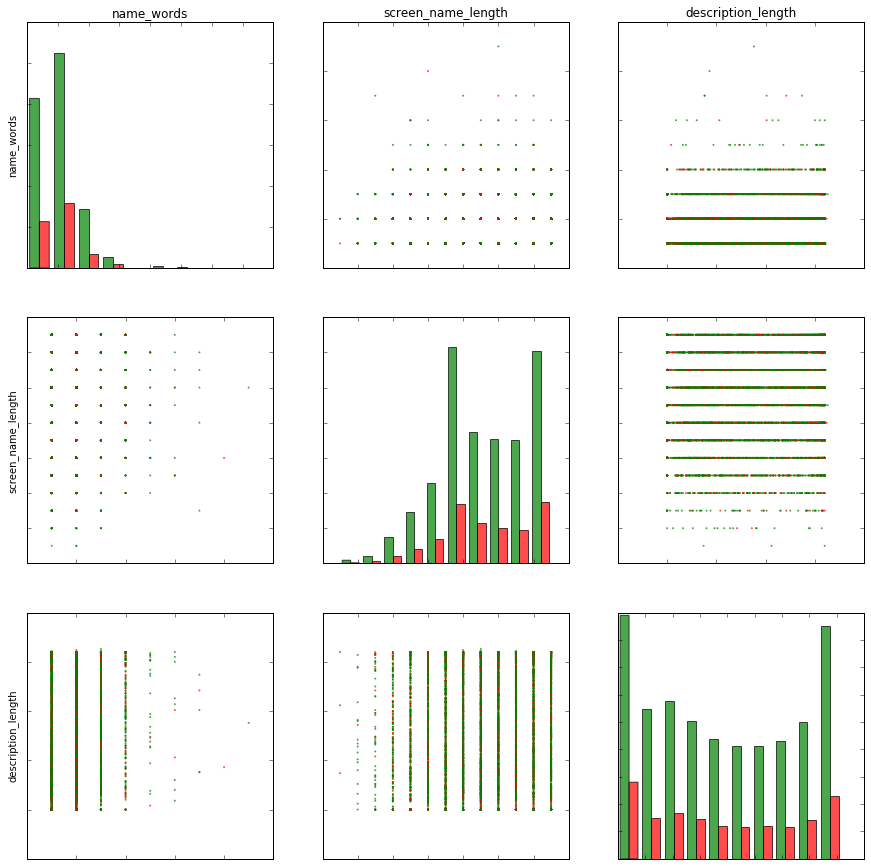

In [272]:
other_features_new = ["name_words", "screen_name_length", "description_length"]

other_features = [f for f in other_features_new if f in features]
other_feature_ind = [features.index(f) for f in other_features]

plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый из которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [273]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]

x_1 = df_users[selected_features].values
y = df_users["cls"].values

# x_1 = x[:, selected_features_ind]
# Replace nan with 0-s
# Is there a smarter way?
x_1[np.isnan(x_1)] = 0
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [274]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=[f for f in selected_features])
df_out.to_csv("hw2_out.csv", sep="\t")

df_out

,followers_count,friends_count,statuses_count,favourites_count,listed_count,created_year,name_words,screen_name_length,description_length
uid,,,,,,,,,
202388889,2.532612e-04,0.006693,0.008612,0.040904,0.000626,0.4,0.125,0.750000,0.227545
1392518336,2.860022e-04,0.002851,0.017534,0.013791,0.002480,0.7,0.125,0.666667,0.952096
361208576,1.526308e-04,0.001967,0.007127,0.002191,0.000626,0.5,0.250,0.416667,0.772455
1535215357,5.686340e-04,0.008312,0.170977,0.168860,0.001519,0.7,0.000,0.666667,0.137725
4396196375,3.002060e-04,0.003282,0.033071,0.051318,0.001676,0.9,0.000,0.833333,0.952096
17938477,7.968580e-05,0.001697,0.004948,0.015374,0.001251,0.2,0.250,1.000000,0.239521
720288026681716737,1.612975e-05,0.000239,0.008515,0.000071,0.001966,1.0,0.125,0.750000,0.514970
174004739,8.883402e-05,0.006416,0.051240,0.254988,0.000603,0.4,0.000,0.750000,0.000000
53783678,1.817607e-04,0.003678,0.035590,0.132868,0.001162,0.3,0.250,0.500000,0.700599
